# Session 2: Python and PYBAMM

## Session 1 Recap

Heat transfer is a branch of engineering science that studies the transfer of energy due to temperature differences *only*

There are wide-ranging applications from aerospace, to materials science, to electrochemical energy storage. 

There are 3 basic and *distinct* modes of heat transfer: conductive, convective and radiative. Convection involves a moving fluid, radiative involves electromagnetic waves

Fourier's Law of Heat Conduction in one dimension: q = -kA dT/dx





# Python Basics

**Python is a programming language that is open source, containing lots of useful libraries, less verbose than C/Java (does the same thing with fewer lines of code) and in 2023, a great scientific computing environment.**

## Packages

In any Python script you first import all your packages like so: 


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Defining variables, and doing math




In [29]:
a = range(0,20)
print(a)

for b in a:
    print(b)



range(0, 20)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## Defining functions

Creating functions allows you to use/call that same function over and over instead of repeating the same lines of code

**remember, syntax for printing something out is print(INSERT_TEXT_HERE)

In [22]:
def function(a,b):
    return a**b
    
print(function(10,2))

100


## Plotting things!

Remember we imported the matplotlib plotting package as "plt" 

First, we create some values to plot (an array of evenly spaced numbers from 0 to 100 and the square of that)

We initialie a figure and then a subplot (111 refers to a 1 by 1 and the first plot. 211 would refer to a 2 by 1 and the first plot, 453 would refer to a 4 by 5 and the third plot, 8,8,63 would refer to a 8 by 8 and the 63 plot..etc..)

We can control this subplot to fine detail..set the x-axis label, y-axis label, title, even specific colors, fonts of each

plt.show to show the plot directly inline 

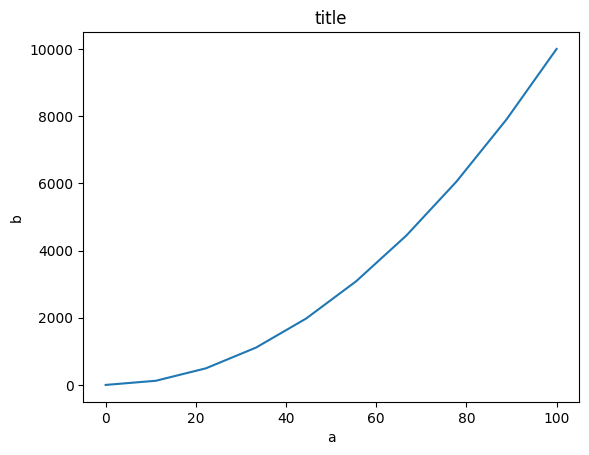

In [21]:
a = np.linspace(0,100,10)
b = a**2 

figure1 = plt.figure()
ax1 = figure1.add_subplot(111)

ax1.plot(a,b)
ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title('title')

plt.show()




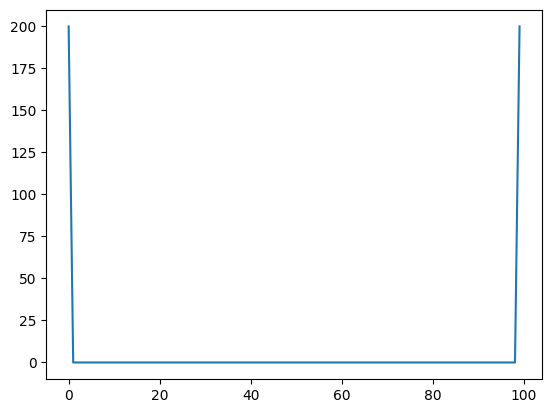

<Figure size 640x480 with 0 Axes>

In [38]:
length = 10               # length of rod
k = .466                  # heat constant of steel
temp_at_left_end = 200    # temperature at left side of rod
temp_at_right_end = 200   # temperature at right side of rod
total_time = 10           # time sim will run for

dx = .1    # space in between points, the smaller the better
# defines the x domain as being from 0 to length and                  # having int(length/dx) points separated by a value dx, will 
# return an array containing all of the points
x_vec = np.linspace(0, length, int(length/dx))    

dt = .0001    # space in between steps in time
# defines the time domain as being from 0 to total_time and                  # having int(total_time/dt) points, separated by steps of 
# value dt, returns an array containing all time steps
t_vec = np.linspace(0, total_time, int(total_time/dt))
# defines an empty 2D numpy array to store the values of u(t, x) as   # we solve for them
u = np.zeros([len(t_vec), len(x_vec)])

u[:, 0] = temp_at_left_end     # u(t, 0) = 200
u[:, -1] = temp_at_right_end   # u(t, length) = 200

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(u[0,:])

plt.show()
plt.clf()


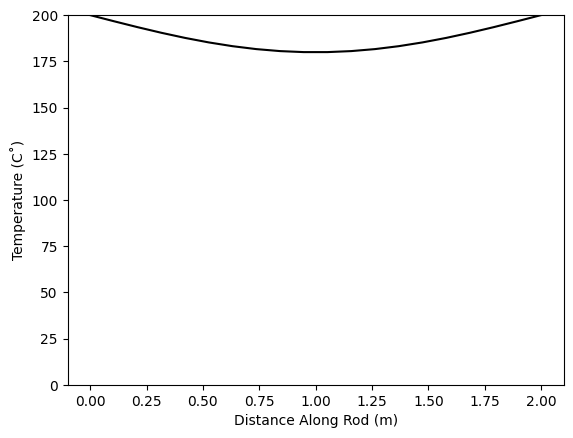

In [49]:
from IPython.display import HTML
from IPython.display import display #these are for displaying the animation in the jupyter notebook 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 

# Define your variables and parameters
length = 2
k = .466
temp_left = 200
temp_right = 200
total_time = 2
dt = 0.01  # Time step
dx = 0.1  # Distance step

# Create time and distance vectors
t_vec = np.linspace(0, total_time, int(total_time/dt))
x_vec = np.linspace(0, length, int(length/dx))

# Initialize the temperature field
u = np.zeros([len(t_vec), len(x_vec)])

# Set initial conditions (e.g., a Gaussian pulse)
u[0] = np.exp(-0.5 * ((x_vec - length / 2) / 2)**2)
u[:, 0] = temp_left
u[:, -1] = temp_right

# Create a figure and axis for the animation
fig, ax = plt.subplots()

def animate(t):
    ax.clear()
    for x in range(1, len(x_vec) - 1):
        u[t + 1, x] = k * (dt / dx**2) * (u[t, x + 1] - 2 * u[t, x] + u[t, x - 1]) + u[t, x]

    ax.plot(x_vec, u[t], 'black')
    ax.set_ylabel("Temperature (C˚)")
    ax.set_xlabel("Distance Along Rod (m)")
    ax.set_ylim(0,200)

# Create the animation
ani = FuncAnimation(fig, animate, frames=len(t_vec)-1, repeat=False, blit=False)
f = 'animate_test.mp4'
# ani.save(f)

display(HTML(ani.to_jshtml()))

plt.show()


In [13]:
import pybamm

## https://docs.pybamm.org/en/latest/source/examples/notebooks/models/thermal-models.html 

full_thermal_model = pybamm.lithium_ion.SPMe(
    {"thermal": "x-full"}, name="full thermal model"
)
lumped_thermal_model = pybamm.lithium_ion.SPMe(
    {"thermal": "lumped"}, name="lumped thermal model"
)
models = [full_thermal_model, lumped_thermal_model]

parameter_values = pybamm.ParameterValues("Marquis2019")

full_params = parameter_values.copy()
full_params.update(
    {
        "Negative current collector"
        + " surface heat transfer coefficient [W.m-2.K-1]": 5,
        "Positive current collector"
        + " surface heat transfer coefficient [W.m-2.K-1]": 5,
        "Negative tab heat transfer coefficient [W.m-2.K-1]": 0,
        "Positive tab heat transfer coefficient [W.m-2.K-1]": 0,
        "Edge heat transfer coefficient [W.m-2.K-1]": 0,
    }
)

A = parameter_values["Electrode width [m]"] * parameter_values["Electrode height [m]"]
lumped_params = parameter_values.copy()
lumped_params.update(
    {
        "Total heat transfer coefficient [W.m-2.K-1]": 5,
        "Cell cooling surface area [m2]": 2 * A,
    }
)

params = [full_params, lumped_params]
# loop over the models and solve
sols = []
for model, param in zip(models, params):
    param["Current function [A]"] = 3 * 0.68
    sim = pybamm.Simulation(model, parameter_values=param)
    sim.solve([0, 3600])
    sols.append(sim.solution)


# plot
output_variables = [
    "Voltage [V]",
    "X-averaged cell temperature [K]",
    "Cell temperature [K]",
]
pybamm.dynamic_plot(sols, output_variables)

# plot the results
pybamm.dynamic_plot(
    sols,
    [
        "Volume-averaged cell temperature [K]",
        "Volume-averaged total heating [W.m-3]",
        "Current [A]",
        "Voltage [V]",
    ],
)


interactive(children=(FloatSlider(value=0.0, description='t', max=1154.876529354234, step=11.54876529354234), …

interactive(children=(FloatSlider(value=0.0, description='t', max=1154.876529354234, step=11.54876529354234), …